In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

In [170]:
# 讀取資料
vix_df = pd.read_csv("VIX_History.csv", parse_dates=['Date'])
txf_df  = pd.read_csv('TXF_R1_1min_data_combined.csv', parse_dates=['datetime'])
# df_0050 = pd.read_excel("0050.xlsx")

In [171]:
# 篩選日盤時間
txf_df = txf_df[
    (txf_df['datetime'].dt.time >= pd.to_datetime('08:45').time()) &
    (txf_df['datetime'].dt.time <= pd.to_datetime('13:45').time())
]
txf_df = txf_df[(txf_df['datetime'] >= '2009-01-01') & (txf_df['datetime'] <= '2025-06-30')]
# 新增一欄日期方便 groupby（只保留年月日）
txf_df['date'] = txf_df['datetime'].dt.date

# 聚合當日日盤資料
txf_df = txf_df.groupby('date').agg(
    Open=('Open', 'first'),
    High=('High', 'max'),
    Low=('Low', 'min'),
    Close=('Close', 'last')
).reset_index()

# 若你想把 date 轉回 datetime
txf_df['datetime'] = pd.to_datetime(txf_df['date'])


In [172]:
# 將VIX時間與台灣時間對齊
vix_df = vix_df.rename(columns={'Close': 'VIX'}).fillna(0)
vix_df = vix_df.rename(columns={'Date': 'datetime'}).fillna(0)
vix_df = vix_df[['datetime', 'VIX']]
vix_df['datetime'] = pd.to_datetime(vix_df['datetime']) + pd.Timedelta(days=1)

# 將資料標準化
txf_df['datetime'] = pd.to_datetime(txf_df['datetime']).dt.normalize()
vix_df['datetime'] = pd.to_datetime(vix_df['datetime']).dt.normalize()

# 合併資料
txf_df = pd.merge(txf_df, vix_df, on='datetime', how='left')
txf_df = txf_df.sort_values('datetime')
txf_df.fillna(method='ffill', inplace=True)
txf_df.at[0, 'VIX'] = 39.19

# 紀錄市場報酬
market_df = txf_df.copy()

C:\Users\herby\AppData\Local\Temp\ipykernel_20116\4014616098.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [173]:
# 技術指標計算
txf_df['High10'] = txf_df['High'].rolling(10).max()
txf_df['Low10'] = txf_df['Low'].rolling(10).min()
txf_df['%R'] = (txf_df['High10'] - txf_df['Close']) / (txf_df['High10'] - txf_df['Low10']) * -100

# txf_df['VIX_10d_max'] = txf_df['VIX'].rolling(3).max()
# txf_df['VIX_10d_new_high'] = txf_df['VIX'] == txf_df['VIX_10d_max']
# txf_df.drop(columns=['VIX_10d_max'], inplace=True)

In [174]:
txf_df['PositionRaw'] = 0
txf_df['EntrySignal'] = 0
txf_df['ExitSignal'] = 0
txf_df['PnL'] = 0.0          # 單日損益（不含成本）
txf_df['Cost'] = 0.0         # 單日交易成本
txf_df['NetPnL'] = 0.0       # 單日淨損益（含成本）
txf_df['Equity'] = 1_000_000 # 資金曲線
txf_df['TradeReturn'] = 0.0  # 每日報酬率
txf_df['TradingDate'] = 0

position = 0
fee_per_trade = 600     # 固定金額，進出各扣一次
capital = 1_000_000     # 初始資金
contract_size = 200     # 大台一點價值

pending_entry = False
pending_exit = False

for i in range(len(txf_df)):
    cost_today = 0.0
    pnl = 0.0

    if i > 0:
        prev_row = txf_df.iloc[i - 1]
        row = txf_df.iloc[i]
        point_diff = row['Close'] - prev_row['Close']

        # 先計算當日損益（基於進入當日的持倉位置）
        if position > 0:
            pnl = point_diff * contract_size

        # 處理前一天的 pending 進出場（在當日執行）
        if pending_exit:
            position = 0
            cost_today += fee_per_trade  # 出場扣費
            pending_exit = False

        if pending_entry:
            position = 1
            cost_today += fee_per_trade  # 進場扣費
            pending_entry = False

        # 計算淨損益並更新資本
        net_pnl = pnl - cost_today
        trade_return = net_pnl / capital if capital > 0 else 0
        capital += net_pnl

        # 存入 DataFrame
        txf_df.at[i, 'PnL'] = pnl
        txf_df.at[i, 'Cost'] = cost_today
        txf_df.at[i, 'NetPnL'] = net_pnl
        txf_df.at[i, 'TradeReturn'] = trade_return
        txf_df.at[i, 'Equity'] = capital

    # 記錄當日結束時的持倉位置
    txf_df.at[i, 'PositionRaw'] = position

    # 檢查當日訊號，為下一天設定 pending（如果不是最後一天）
    if i < len(txf_df) - 1:
        row = txf_df.iloc[i]

        # 進出場訊號（訊號產生，但延遲到下一天執行）
        long_signal = (row['%R'] < -95) and (row['VIX'] > 18)
        exit_signal = (row['%R'] > -1)

        # 出場訊號（包含原邏輯的 or long_signal，以避免重複進場）
        if position > 0 and (exit_signal or long_signal):
            pending_exit = True
            txf_df.at[i, 'ExitSignal'] = 1  # 標記訊號日（實際執行在 i+1）

        # 進場訊號（無論是否持倉，如果有新訊號且需先出場，則在出場後進場）
        if long_signal:
            pending_entry = True
            txf_df.at[i, 'EntrySignal'] = 1  # 標記訊號日（實際執行在 i+1）

# 標記交易區間
in_trade = False
for i in range(len(txf_df)):
    if txf_df.at[i, 'PositionRaw'] == 1 and not in_trade:
        in_trade = True
    if in_trade:
        txf_df.at[i, 'TradingDate'] = 1
    if in_trade and txf_df.at[i, 'PositionRaw'] == 0 and (i > 0 and txf_df.at[i - 1, 'PositionRaw'] == 1):
        in_trade = False

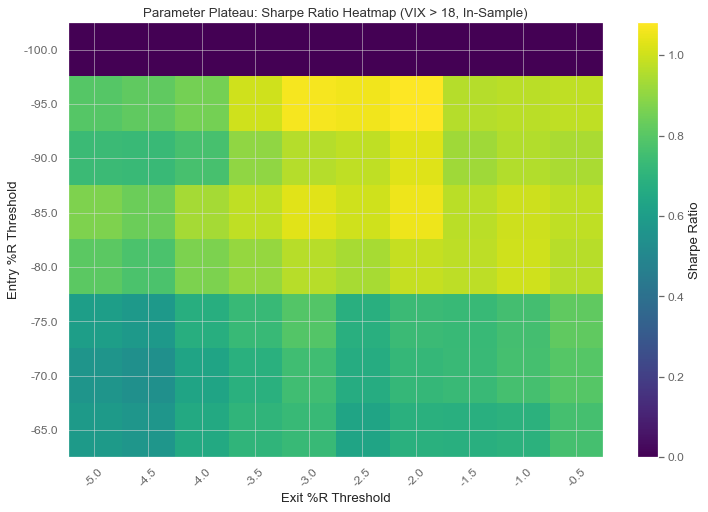

Best Parameters (In-Sample): Entry %R < -95, Exit %R > -2.0, Sharpe: 1.08


In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 篩選樣本內資料（2020/01/01 以前） ---
txf_df['datetime'] = pd.to_datetime(txf_df['datetime'])
txf_in_sample = txf_df[txf_df['datetime'] < '2020-01-01'].copy()

# --- 參數最佳化函數 ---
def backtest(txf_df, entry_th, exit_th, vix_th=18):
    txf_df = txf_df.copy()
    txf_df['PositionRaw'] = 0
    txf_df['EntrySignal'] = 0
    txf_df['ExitSignal'] = 0
    txf_df['PnL'] = 0.0
    txf_df['Cost'] = 0.0
    txf_df['NetPnL'] = 0.0
    txf_df['Equity'] = 1_000_000
    txf_df['TradeReturn'] = 0.0
    txf_df['TradingDate'] = 0

    position = 0
    fee_per_trade = 600
    capital = 1_000_000
    contract_size = 200

    pending_entry = False
    pending_exit = False

    for i in range(len(txf_df)):
        cost_today = 0.0
        pnl = 0.0

        if i > 0:
            prev_row = txf_df.iloc[i - 1]
            row = txf_df.iloc[i]
            point_diff = row['Close'] - prev_row['Close']

            if position > 0:
                pnl = point_diff * contract_size

            if pending_exit:
                position = 0
                cost_today += fee_per_trade
                pending_exit = False

            if pending_entry:
                position = 1
                cost_today += fee_per_trade
                pending_entry = False

            net_pnl = pnl - cost_today
            trade_return = net_pnl / capital if capital > 0 else 0
            capital += net_pnl

            txf_df.at[i, 'PnL'] = pnl
            txf_df.at[i, 'Cost'] = cost_today
            txf_df.at[i, 'NetPnL'] = net_pnl
            txf_df.at[i, 'TradeReturn'] = trade_return
            txf_df.at[i, 'Equity'] = capital

        txf_df.at[i, 'PositionRaw'] = position

        if i < len(txf_df) - 1:
            row = txf_df.iloc[i]
            long_signal = (row['%R'] < entry_th) and (row['VIX'] > vix_th)
            exit_signal = (row['%R'] > exit_th)

            if position > 0 and (exit_signal or long_signal):
                pending_exit = True
                txf_df.at[i, 'ExitSignal'] = 1

            if long_signal:
                pending_entry = True
                txf_df.at[i, 'EntrySignal'] = 1

    returns = txf_df['TradeReturn']
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 1 and np.std(returns) != 0 else 0.0
    return sharpe, txf_df['Equity'].iloc[-1]

# --- 最佳化參數範圍 ---
entry_th_range = np.arange(-100, -60, 5)  # %R 進場門檻
exit_th_range = np.arange(-5, 0, 0.5)    # %R 出場門檻

# --- 收集結果 ---
results = []
for entry_th in entry_th_range:
    for exit_th in exit_th_range:
        sharpe, final_equity = backtest(txf_in_sample, entry_th, exit_th, vix_th=18)
        results.append({'entry_th': entry_th, 'exit_th': exit_th, 'sharpe': sharpe, 'final_equity': final_equity})

results_df = pd.DataFrame(results)

# --- 繪製參數高原熱圖 ---
pivot_sharpe = results_df.pivot(index='entry_th', columns='exit_th', values='sharpe')
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(pivot_sharpe.values, cmap='viridis', aspect='auto')

ax.set_xticks(np.arange(len(exit_th_range)))
ax.set_yticks(np.arange(len(entry_th_range)))
ax.set_xticklabels([f'{x:.1f}' for x in exit_th_range], rotation=45)
ax.set_yticklabels([f'{x:.1f}' for x in entry_th_range])
plt.colorbar(im, label='Sharpe Ratio')
ax.set_xlabel('Exit %R Threshold')
ax.set_ylabel('Entry %R Threshold')
ax.set_title('Parameter Plateau: Sharpe Ratio Heatmap (VIX > 18, In-Sample)')

plt.show()

# --- 印出最佳參數 ---
best_idx = results_df['sharpe'].idxmax()
best_entry = results_df.loc[best_idx, 'entry_th']
best_exit = results_df.loc[best_idx, 'exit_th']
best_sharpe = results_df.loc[best_idx, 'sharpe']
print(f'Best Parameters (In-Sample): Entry %R < {best_entry}, Exit %R > {best_exit}, Sharpe: {best_sharpe:.2f}')


In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_metrics(txf_df, initial_capital=1_000_000, trading_days=252):
    txf_df = txf_df.copy()
    txf_df['datetime'] = pd.to_datetime(txf_df['datetime'])
    
    # --- 計算每日報酬率 (%)
    equity = txf_df['Equity']
    prev_equity = equity.shift(1).fillna(initial_capital)
    daily_returns = equity.pct_change().fillna(0)  # 使用前日 Equity 計算報酬率

    # --- Sharpe Ratio ---
    sharpe = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(trading_days) if np.std(daily_returns) != 0 else np.nan

    # --- 下行波動與 Sortino Ratio ---
    target = 0.0
    downside_returns = np.minimum(daily_returns - target, 0)
    downside_vol = np.std(downside_returns) * np.sqrt(trading_days) if len(downside_returns) > 0 else np.nan
    sortino = (np.mean(daily_returns) - target) * np.sqrt(trading_days) / downside_vol if downside_vol != 0 else np.nan

    # --- Drawdown & Max Losing Streak ---
    rolling_max = equity.cummax()
    drawdowns = (rolling_max - equity) / rolling_max
    mdd = drawdowns.max()

    # 計算連續虧損天數
    dd_flag = drawdowns > 0
    max_losing_streak = (dd_flag.groupby((dd_flag != dd_flag.shift()).cumsum()).cumsum()).max()

    # --- 年化報酬 & 總報酬 ---
    n_years = (txf_df['datetime'].iloc[-1] - txf_df['datetime'].iloc[0]).days / 365.25
    final_equity = equity.iloc[-1]
    total_return = final_equity / initial_capital - 1
    cagr = (final_equity / initial_capital) ** (1 / n_years) - 1 if n_years > 0 else np.nan

    # --- Risk-Return & Calmar ---
    risk_return_ratio = total_return / mdd if mdd > 0 else np.inf
    calmar_ratio = cagr / mdd if mdd > 0 else np.inf

    # --- 年化波動度 ---
    annualized_vol = np.std(daily_returns) * np.sqrt(trading_days)

    # --- 日報酬統計 ---
    avg_daily_return = np.mean(daily_returns)
    avg_daily_loss = np.mean(daily_returns[daily_returns < 0]) if len(daily_returns[daily_returns < 0]) > 0 else 0.0

    # --- 勝率 & Profit Factor ---
    returns = txf_df['TradeReturn']
    positive_returns = returns[returns >= 0]
    negative_returns = returns[returns < 0]
    win_rate = len(positive_returns) / len(returns) if len(returns) > 0 else np.nan
    profit_factor = positive_returns.sum() / abs(negative_returns.sum()) if len(negative_returns) > 0 else np.inf

    return {
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': mdd,
        'Max Losing Streak (days)': max_losing_streak,
        'Annualized Return': cagr,
        'Total Return': total_return,
        'Risk-Return Ratio': risk_return_ratio,
        'Calmar Ratio': calmar_ratio,
        'Annualized Volatility': annualized_vol,
        'Average Daily Return': avg_daily_return,
        'Average Daily Loss': avg_daily_loss,
        'Win Rate (daily, >=0)': win_rate,
        'Profit Factor (daily, >=0)': profit_factor,
        'Total Days': len(returns)
    }


# --- 分樣本內 / 樣本外 ---
split_date = pd.Timestamp("2020-01-01")
in_sample = txf_df[txf_df['datetime'] < split_date]
out_sample = txf_df[txf_df['datetime'] >= split_date]

metrics_in = calculate_metrics(in_sample) if not in_sample.empty else {}
# 樣本外初始資金接樣本內結束時的 Equity
out_initial_capital = in_sample['Equity'].iloc[-1] if not in_sample.empty else 1_000_000
metrics_out = calculate_metrics(out_sample, initial_capital=out_initial_capital) if not out_sample.empty else {}
metrics_all = calculate_metrics(txf_df)

# --- 整理成 DataFrame ---
metrics_df = pd.DataFrame([metrics_all, metrics_in, metrics_out],
                          index=['Overall', 'In-sample (<2020)', 'Out-of-sample (>=2020)'])

# 轉置表格，指標在行，樣本在欄
metrics_df = metrics_df.T

# 格式化顯示
pd.set_option('display.float_format', '{:.2f}'.format)
print(metrics_df)


                            Overall  In-sample (<2020)  Out-of-sample (>=2020)
Sharpe Ratio                   0.86               0.97                    0.75
Sortino Ratio                  0.08               0.10                    0.07
Max Drawdown                   0.29               0.19                    0.29
Max Losing Streak (days)     605.00             317.00                  605.00
Annualized Return              0.09               0.09                    0.10
Total Return                   3.45               1.68                    0.66
Risk-Return Ratio             11.86               8.67                    2.28
Calmar Ratio                   0.33               0.48                    0.33
Annualized Volatility          0.12               0.10                    0.14
Average Daily Return           0.00               0.00                    0.00
Average Daily Loss            -0.01              -0.01                   -0.01
Win Rate (daily, >=0)          0.83               0.

In [177]:
# 報酬可視化
txf_df['date'] = pd.to_datetime(txf_df['date'])
txf_df['Year'] = txf_df['date'].dt.year
txf_df['Month'] = txf_df['date'].dt.month
txf_df['Day'] = txf_df['date'].dt.day


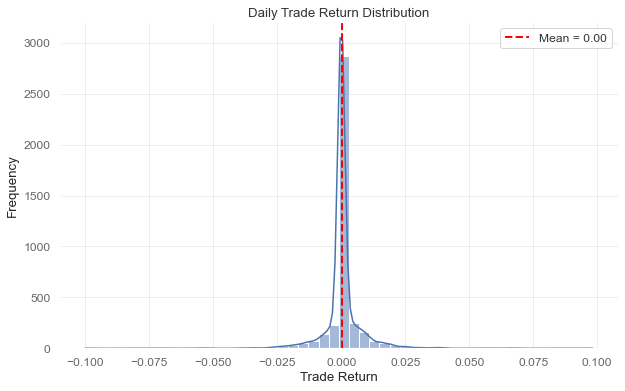

In [178]:
# 每日報酬直方圖
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(txf_df['TradeReturn'], bins=50, kde=True)

# 計算平均值
mean_return = txf_df['TradeReturn'].mean()

# 畫平均線
plt.axvline(mean_return, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_return:.2f}')

plt.title('Daily Trade Return Distribution')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

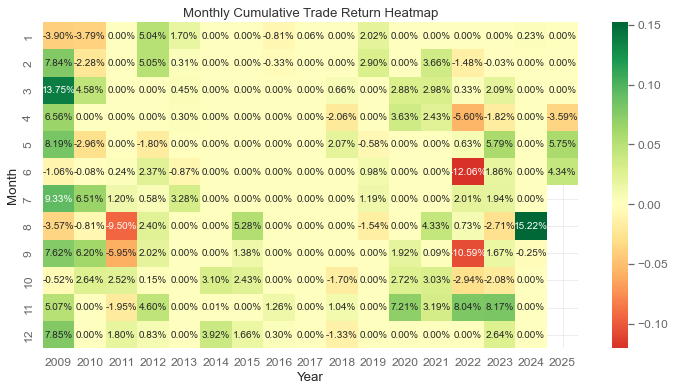

In [179]:
# 每月報酬熱力圖
monthly_return = txf_df.groupby(['Year','Month'])['TradeReturn'].sum().unstack(level=0)

plt.figure(figsize=(12,6))
sns.heatmap(monthly_return, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title('Monthly Cumulative Trade Return Heatmap')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


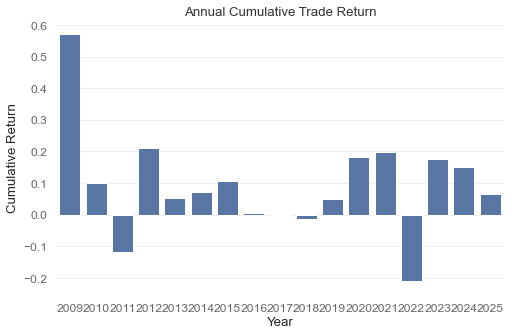

In [180]:
# 每年報酬直方圖
annual_return = txf_df.groupby('Year')['TradeReturn'].sum()

plt.figure(figsize=(8,5))
sns.barplot(x=annual_return.index, y=annual_return.values)
plt.title('Annual Cumulative Trade Return')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.show()


In [181]:
# 計算策略單利累積報酬
txf_df['CumsumReturn'] = txf_df['TradeReturn'].cumsum()

market_df['Return'] = market_df['Close'].pct_change().shift(1)
market_df['SimpleReturn'] = market_df['Return'].cumsum()

# # 計算0050報酬 (買進手續費 0.1425% + 賣出交易稅 0.3% = 總一次性成本 ≈ 0.4425%)
# # 0050每年管理費率約 0.42% 每日費率約 0.42% / 252 = 0.0000166667
# df_0050['Return'] = (df_0050['Close'].pct_change().shift(1)) * (1 - 0.000035)
# df_0050['SimpleReturn'] = df_0050['Return'].cumsum()

In [182]:
import plotly.express as px
# trading_date(包含holing)
# 假設 txf_df['datetime'] 是 datetime 格式
trading_dates = txf_df.loc[txf_df['TradingDate'] == 1, 'datetime']
plot_df = pd.DataFrame({'TradingDay': trading_dates})

# 繪製互動式散點圖
fig = px.scatter(plot_df, x='TradingDay', y=[1] * len(trading_dates), 
                 title='Trading Days Timeline',
                 labels={'TradingDay': 'Date'},
                 hover_data={'TradingDay': True})
fig.update_yaxes(visible=False)  # 隱藏 Y 軸
fig.update_traces(marker=dict(size=10, symbol='line-ns-open'))
fig.show()

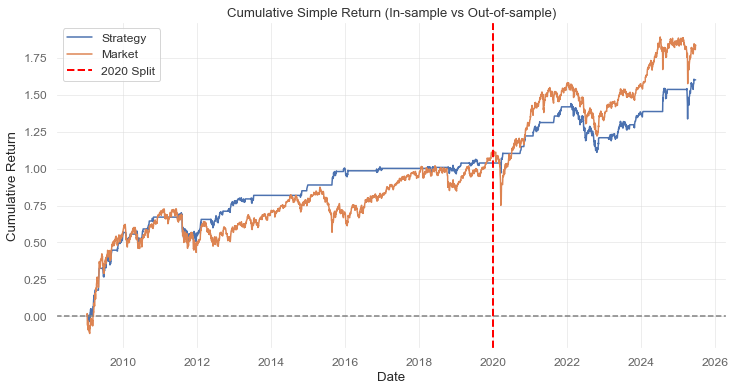

In [183]:
# 畫圖
plt.figure(figsize=(12,6))

# 策略 vs. 市場
plt.plot(txf_df['datetime'], txf_df['CumsumReturn'], label='Strategy')
plt.plot(market_df['datetime'], market_df['SimpleReturn'], label='Market')

# 標出 y=0
plt.axhline(0, color='gray', linestyle='--')

# 標出 2020 年切點
plt.axvline(pd.Timestamp("2020-01-01"), color='red', linestyle='--', linewidth=2, label='2020 Split')

plt.legend()
plt.title('Cumulative Simple Return (In-sample vs Out-of-sample)')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python3

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-01-05  2009-01-05
End Period                 2025-06-27  2025-06-27
Risk-Free Rate             0.0%        0.0%
Time in Market             38.0%       100.0%

Cumulative Return          345.48%     369.97%
CAGR﹪                     9.49%       9.84%

Sharpe                     0.86        0.61
Prob. Sharpe Ratio         99.97%      99.22%
Smart Sharpe               0.83        0.59
Sortino                    1.29        0.85
Smart Sortino              1.24        0.82
Sortino/√2                 0.91        0.6
Smart Sortino/√2           0.88        0.58
Omega                      1.3         1.3

Max Drawdown               -29.13%     -31.51%
Longest DD Days            908         1217
Volatility (ann.)          11.58%      18.67%
R^2                        0.0         0.0
Information Ratio          -0.0        -0.0
Calmar                     0.33        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-02-11,2022-10-25,2024-08-07,908,-29.13,-27.81
2,2024-08-21,2025-04-09,2025-05-14,266,-19.64,-12.24
3,2011-07-28,2011-09-26,2012-11-02,463,-19.35,-17.99
4,2019-07-17,2020-03-19,2020-03-26,253,-9.25,-4.48
5,2010-01-04,2010-02-06,2010-05-13,129,-8.74,-8.68


c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

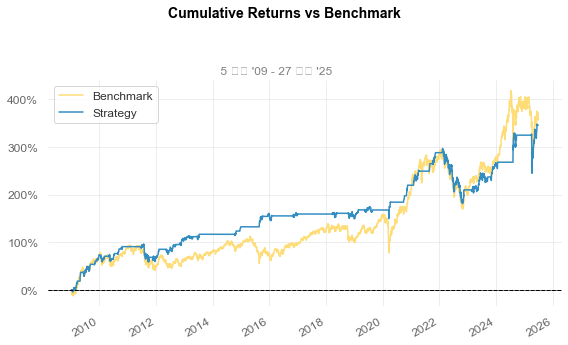

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

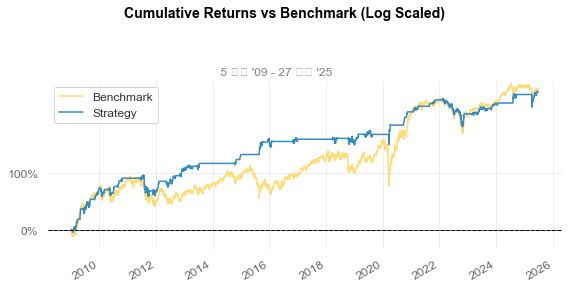

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

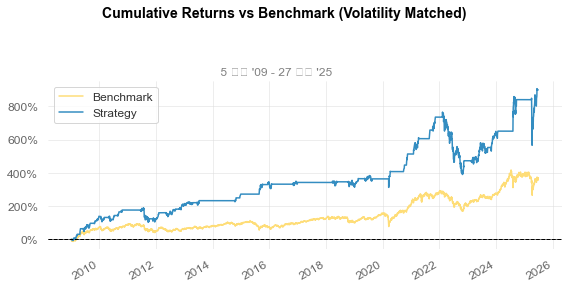

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:376: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:377: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:383: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:386: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.



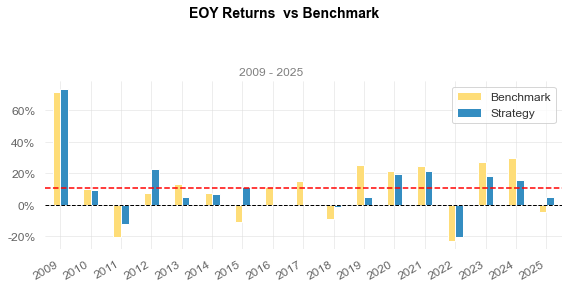

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:325: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:326: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



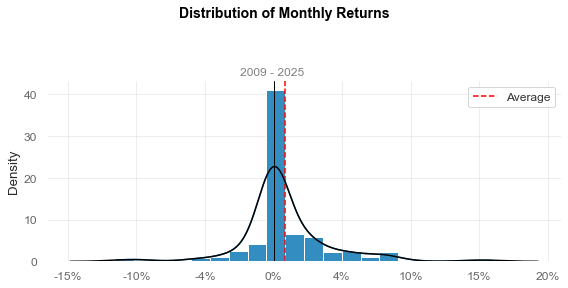

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

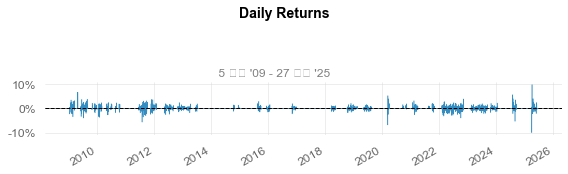

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:540: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:540: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:540: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

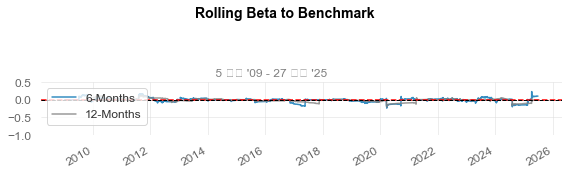

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

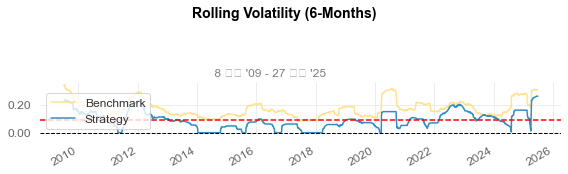

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

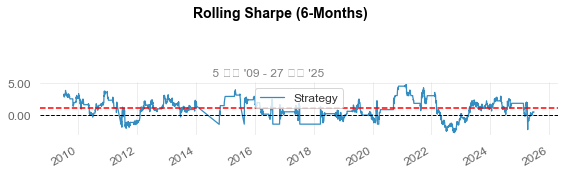

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:462: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

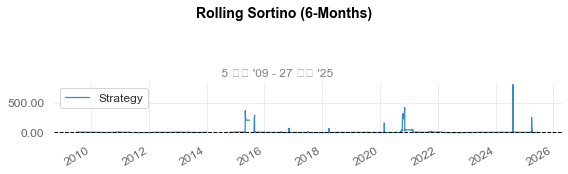

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:626: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:626: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:626: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

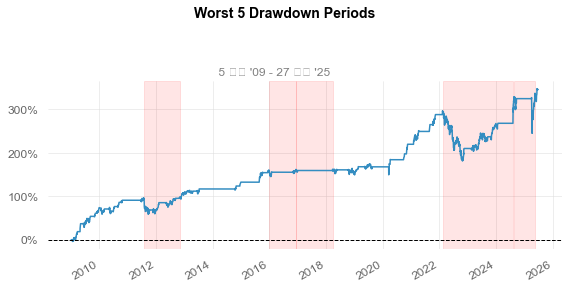

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:293: UserWarning:

Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) Arial.

c:\Users\herby\AppData\Local\

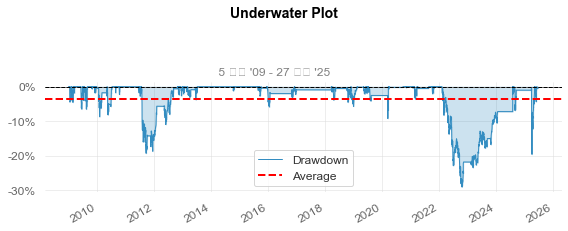

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [184]:
strategy_returns = txf_df.set_index('datetime')["TradeReturn"]
benchmark = market_df.set_index('datetime')["Return"]
qs.reports.full(strategy_returns,benchmark=benchmark)